In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [3]:
# Download SPY (S&P 500 ETF) data
spy = yf.download("SPY", start="2018-01-01")
spy.head()

C:\Users\christian-vs\AppData\Local\Temp\1\ipykernel_49356\807870434.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2018-01-02,237.909119,237.944533,236.696430,237.085910,86655700
2018-01-03,239.413895,239.564387,238.077268,238.077268,90070400
2018-01-04,240.422974,240.909837,239.475855,240.060075,80636400
2018-01-05,242.025223,242.149134,240.724011,241.219708,83524000
2018-01-08,242.467804,242.627129,241.635735,241.927832,57319200


## Calculate Daily Log Returns

In [11]:
# Use adjusted close prices - squeeze to get Series
prices = spy["Close"].squeeze()

# Calculate daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Create time series dataframe
ts = pd.DataFrame({"R": returns})
ts

,R
Date,
2018-01-03,0.006305
2018-01-04,0.004206
2018-01-05,0.006642
2018-01-08,0.001827
2018-01-09,0.002261
...,...
2025-11-28,0.005444
2025-12-01,-0.004576
2025-12-02,0.001851


## Visualize Returns Time Series

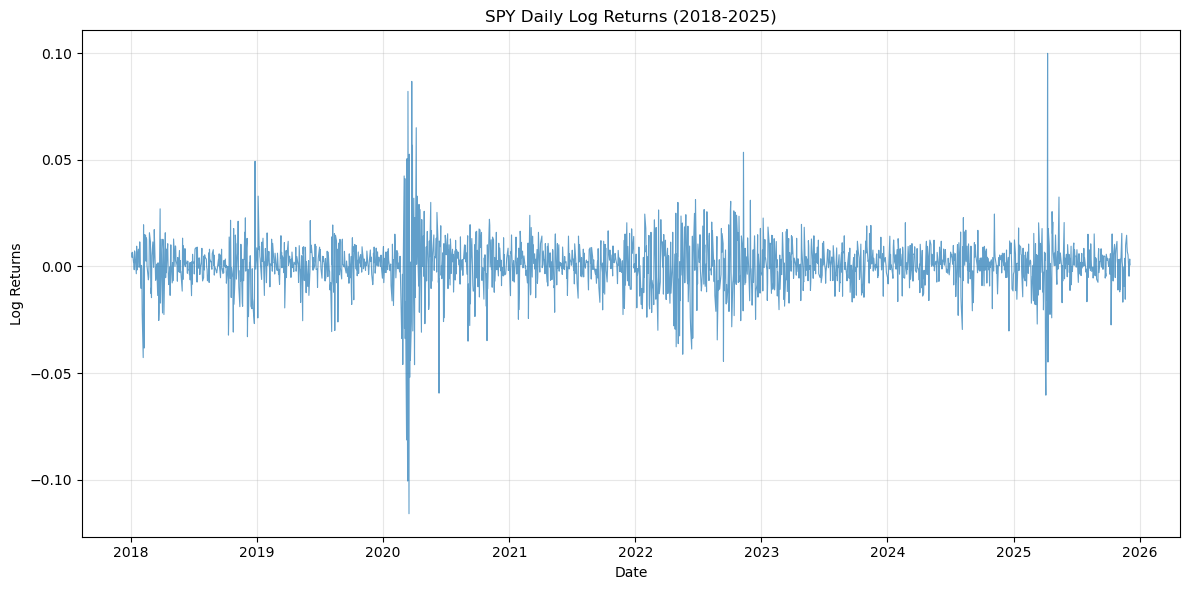

In [12]:
import matplotlib.pyplot as plt

# Plot returns over time
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts["R"], linewidth=0.8, alpha=0.7)
plt.title("SPY Daily Log Returns (2018-2025)")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## AR(1) Model - Autoregressive Model of Order 1

An AR(1) model assumes that today's return depends on yesterday's return plus random noise:

$$R_t = \phi_1 R_{t-1} + \epsilon_t$$

where $\epsilon_t \sim N(0, \sigma^2)$

### Intuition
- We model today's return as a linear function of yesterday's return
- If $\phi_1 > 0$: positive returns tend to follow positive returns (momentum)
- If $\phi_1 < 0$: positive returns tend to follow negative returns (mean reversion)
- The error term $\epsilon_t$ captures random shocks that cannot be predicted from past returns

In [14]:
import statsmodels.api as sm

# Fit AR(1) model (ARIMA with p=1, d=0, q=0)
ar1_model = sm.tsa.ARIMA(ts["R"], order=(1, 0, 0))
ar1_res = ar1_model.fit()

print("AR(1) Model Summary:")
print(ar1_res.summary())

# Extract parameters
phi1 = ar1_res.params.get("ar.L1", None)
sigma2_ar = ar1_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"φ₁ (AR coefficient) = {phi1:.4f}")
print(f"σ² (innovation variance) = {sigma2_ar:.6f}")
print(f"{'='*50}")

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5948.719
Date:                Thu, 04 Dec 2025   AIC                         -11891.438
Time:                        23:22:57   BIC                         -11874.648
Sample:                             0   HQIC                        -11885.272
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.119      0.034    3.96e-05       0.001
ar.L1         -0.1355      0.009    -14.507      0.000      -0.154      -0.117
sigma2         0.0001   1.85e-0

## MA(1) Model - Moving Average Model of Order 1

An MA(1) model assumes that today's return depends on today's and yesterday's random shocks:

$$R_t = \epsilon_t + \theta_1 \epsilon_{t-1}$$

where $\epsilon_t \sim N(0, \sigma^2)$
### Intuition
- We model today's return as depending on today's random shock plus a weighted version of yesterday's shock
- If $\theta_1 > 0$: a positive shock yesterday increases today's expected return (positive shock persistence)
- If $\theta_1 < 0$: a positive shock yesterday decreases today's expected return (shock reversal)
- Unlike AR(1), MA(1) focuses on how past forecast errors (shocks) affect current values
- MA models are useful when returns show short-term dependencies in their innovations rather than in the returns themselves

In [15]:
# Fit MA(1) model (ARIMA with p=0, d=0, q=1)
ma1_model = sm.tsa.ARIMA(ts["R"], order=(0, 0, 1))
ma1_res = ma1_model.fit()

print("MA(1) Model Summary:")
print(ma1_res.summary())

# Extract parameters
theta1 = ma1_res.params.get("ma.L1", None)
sigma2_ma = ma1_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"θ₁ (MA coefficient) = {theta1:.4f}")
print(f"σ² (innovation variance) = {sigma2_ma:.6f}")
print(f"{'='*50}")

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MA(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5946.099
Date:                Thu, 04 Dec 2025   AIC                         -11886.198
Time:                        23:24:18   BIC                         -11869.408
Sample:                             0   HQIC                        -11880.032
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.082      0.037    3.08e-05       0.001
ma.L1         -0.1253      0.010    -12.368      0.000      -0.145      -0.105
sigma2         0.0001   1.84e-0

## Model Comparison Summary

In [16]:
# Create comparison table
summary = pd.DataFrame({
    "Model": ["AR(1)", "MA(1)"],
    "Coefficient": [phi1, theta1],
    "σ² (Innovation Variance)": [sigma2_ar, sigma2_ma],
    "AIC": [ar1_res.aic, ma1_res.aic],
    "BIC": [ar1_res.bic, ma1_res.bic]
})

summary

,Model,Coefficient,σ² (Innovation Variance),AIC,BIC
0,AR(1),-0.135538,0.000149,-11891.438452,-11874.647769
1,MA(1),-0.125284,0.000149,-11886.198257,-11869.407574


## ARIMA(p,d,q) - General Form

ARIMA combines:
- **AR(p)**: Autoregressive component (uses past values)
- **I(d)**: Integration/Differencing (makes series stationary)
- **MA(q)**: Moving average component (uses past errors)

General form: ARIMA(p,d,q)

$$\phi(B)(1-B)^d y_t = \theta(B)\epsilon_t$$

where:
- $\phi(B)$ is the AR polynomial
- $(1-B)^d$ is the differencing operator
- $\theta(B)$ is the MA polynomial
- $\epsilon_t$ is white noise

For stationary returns, d=0 is typical.

In [18]:
# Fit ARIMA(2,0,1) - combines AR(2) and MA(1)
arima_model = sm.tsa.ARIMA(ts["R"], order=(2, 0, 1))
arima_res = arima_model.fit()

print("ARIMA(2,0,1) Model Summary:")
print(arima_res.summary())

# Extract parameters
ar_coefs = [arima_res.params.get(f"ar.L{i}", None) for i in range(1, 3)]
ma_coef = arima_res.params.get("ma.L1", None)
sigma2_arima = arima_res.params.get("sigma2", None)

print(f"\n{'='*50}")
print(f"φ₁ (AR coefficient 1) = {ar_coefs[0]:.4f}")
print(f"φ₂ (AR coefficient 2) = {ar_coefs[1]:.4f}")
print(f"θ₁ (MA coefficient) = {ma_coef:.4f}")
print(f"σ² (innovation variance) = {sigma2_arima:.6f}")
print(f"{'='*50}")

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2,0,1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      R   No. Observations:                 1992
Model:                 ARIMA(2, 0, 1)   Log Likelihood                5954.175
Date:                Thu, 04 Dec 2025   AIC                         -11898.349
Time:                        23:25:48   BIC                         -11870.365
Sample:                             0   HQIC                        -11888.072
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.855      0.064   -2.99e-05       0.001
ar.L1         -0.1946      0.137     -1.420      0.156      -0.463       0.074
ar.L2          0.0646   

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Updated Model Comparison

In [19]:
# Extended comparison table including ARIMA
summary_extended = pd.DataFrame({
    "Model": ["AR(1)", "MA(1)", "ARIMA(2,0,1)"],
    "Parameters": ["φ₁", "θ₁", "φ₁, φ₂, θ₁"],
    "σ²": [sigma2_ar, sigma2_ma, sigma2_arima],
    "AIC": [ar1_res.aic, ma1_res.aic, arima_res.aic],
    "BIC": [ar1_res.bic, ma1_res.bic, arima_res.bic],
    "Log-Likelihood": [ar1_res.llf, ma1_res.llf, arima_res.llf]
})

# Highlight best model (lowest AIC)
print("Lower AIC/BIC indicates better model fit")
print("="*60)
summary_extended

Lower AIC/BIC indicates better model fit


,Model,Parameters,σ²,AIC,BIC,Log-Likelihood
0,AR(1),φ₁,0.000149,-11891.438452,-11874.647769,5948.719226
1,MA(1),θ₁,0.000149,-11886.198257,-11869.407574,5946.099129
2,"ARIMA(2,0,1)","φ₁, φ₂, θ₁",0.000148,-11898.349270,-11870.364798,5954.174635


## ARIMA Model Diagnostics

Let's check how well the ARIMA(2,0,1) model captures the data patterns.

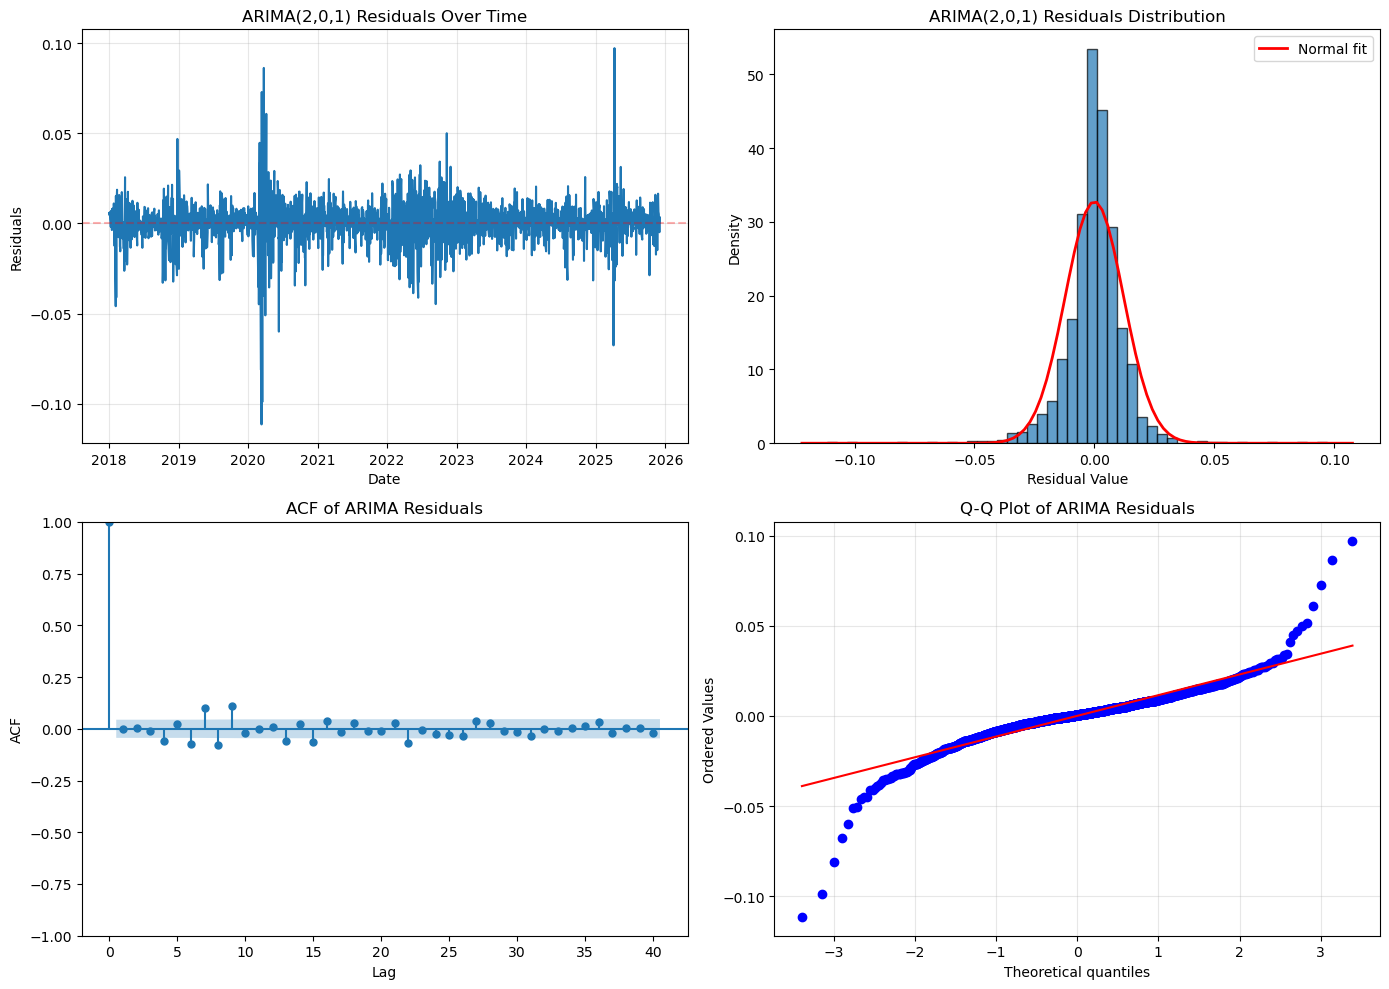


Ljung-Box Test (tests for no autocorrelation in residuals):
H0: No autocorrelation (p > 0.05 means residuals look like white noise)
       lb_stat     lb_pvalue
10   78.780980  8.699235e-13
20  101.367955  7.162729e-13
30  123.413606  2.719893e-13


In [20]:
# Plot ARIMA residuals
arima_residuals = arima_res.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series of residuals
axes[0, 0].plot(arima_residuals)
axes[0, 0].set_title("ARIMA(2,0,1) Residuals Over Time")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(arima_residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0, 1].set_title("ARIMA(2,0,1) Residuals Distribution")
axes[0, 1].set_xlabel("Residual Value")
axes[0, 1].set_ylabel("Density")

# Add normal distribution overlay
from scipy import stats
mu, std = arima_residuals.mean(), arima_residuals.std()
xmin, xmax = axes[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0, 1].plot(x, p, 'r-', linewidth=2, label='Normal fit')
axes[0, 1].legend()

# ACF of residuals
plot_acf(arima_residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF of ARIMA Residuals")
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("ACF")

# Q-Q plot
stats.probplot(arima_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of ARIMA Residuals")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(arima_residuals, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test (tests for no autocorrelation in residuals):")
print("H0: No autocorrelation (p > 0.05 means residuals look like white noise)")
print("="*60)
print(lb_test)

## Auto ARIMA - Automatic Model Selection

Auto ARIMA automatically searches through different combinations of (p,d,q) to find the best model based on information criteria (AIC/BIC).

In [22]:
# Install pmdarima if not already installed
# !pip install pmdarima

from pmdarima import auto_arima

# Perform auto ARIMA search
print("Searching for best ARIMA model...")
print("This may take a moment...\n")

auto_model = auto_arima(
    ts["R"],
    start_p=0, start_q=0,           # Starting values
    max_p=5, max_q=5,                # Maximum values to search
    d=0,                             # We know returns are stationary (d=0)
    seasonal=False,                  # No seasonality in daily returns
    stepwise=True,                   # Use stepwise search (faster)
    trace=True,                      # Print progress
    error_action='ignore',           # Ignore orders that don't converge
    suppress_warnings=True,          # Suppress convergence warnings
    information_criterion='aic'      # Use AIC for selection
)

print("\n" + "="*60)
print("BEST MODEL SELECTED:")
print("="*60)
print(auto_model.summary())

Searching for best ARIMA model...
This may take a moment...

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11854.833, Time=0.14 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11888.615, Time=0.20 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11883.558, Time=0.40 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-11898.249, Time=0.26 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-11896.268, Time=0.63 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11896.232, Time=0.42 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11890.984, Time=0.26 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-11894.316, Time=0.51 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-11900.405, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-11891.438, Time=0.21 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-11898.457, Time=0.79 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-11898.355, Time=0.47 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11896.790, Time=1.04 sec


c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-11896.543, Time=0.64 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 6.571 seconds

BEST MODEL SELECTED:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1992
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5954.202
Date:                Thu, 04 Dec 2025   AIC                         -11900.405
Time:                        23:29:48   BIC                         -11878.017
Sample:                             0   HQIC                        -11892.183
                               - 1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      1.909

### Compare Auto-Selected Model with Manual Models

In [23]:
# Extract auto-selected model order
auto_order = auto_model.order
print(f"Auto-selected model: ARIMA{auto_order}")
print(f"AIC: {auto_model.aic():.2f}")
print(f"BIC: {auto_model.bic():.2f}")

# Create comprehensive comparison
final_comparison = pd.DataFrame({
    "Model": ["AR(1)", "MA(1)", "ARIMA(2,0,1)", f"Auto: ARIMA{auto_order}"],
    "AIC": [ar1_res.aic, ma1_res.aic, arima_res.aic, auto_model.aic()],
    "BIC": [ar1_res.bic, ma1_res.bic, arima_res.bic, auto_model.bic()],
    "Log-Likelihood": [ar1_res.llf, ma1_res.llf, arima_res.llf, auto_model.arima_res_.llf]
})

# Sort by AIC (lower is better)
final_comparison = final_comparison.sort_values('AIC').reset_index(drop=True)
final_comparison['Rank'] = range(1, len(final_comparison) + 1)

print("\n" + "="*60)
print("MODEL COMPARISON (sorted by AIC, lower is better)")
print("="*60)
final_comparison

Auto-selected model: ARIMA(2, 0, 0)
AIC: -11900.40
BIC: -11878.02

MODEL COMPARISON (sorted by AIC, lower is better)


,Model,AIC,BIC,Log-Likelihood,Rank
0,"Auto: ARIMA(2, 0, 0)",-11900.404627,-11878.017049,5954.202313,1
1,"ARIMA(2,0,1)",-11898.349270,-11870.364798,5954.174635,2
2,AR(1),-11891.438452,-11874.647769,5948.719226,3
3,MA(1),-11886.198257,-11869.407574,5946.099129,4


### Visualize Auto-Selected Model Performance

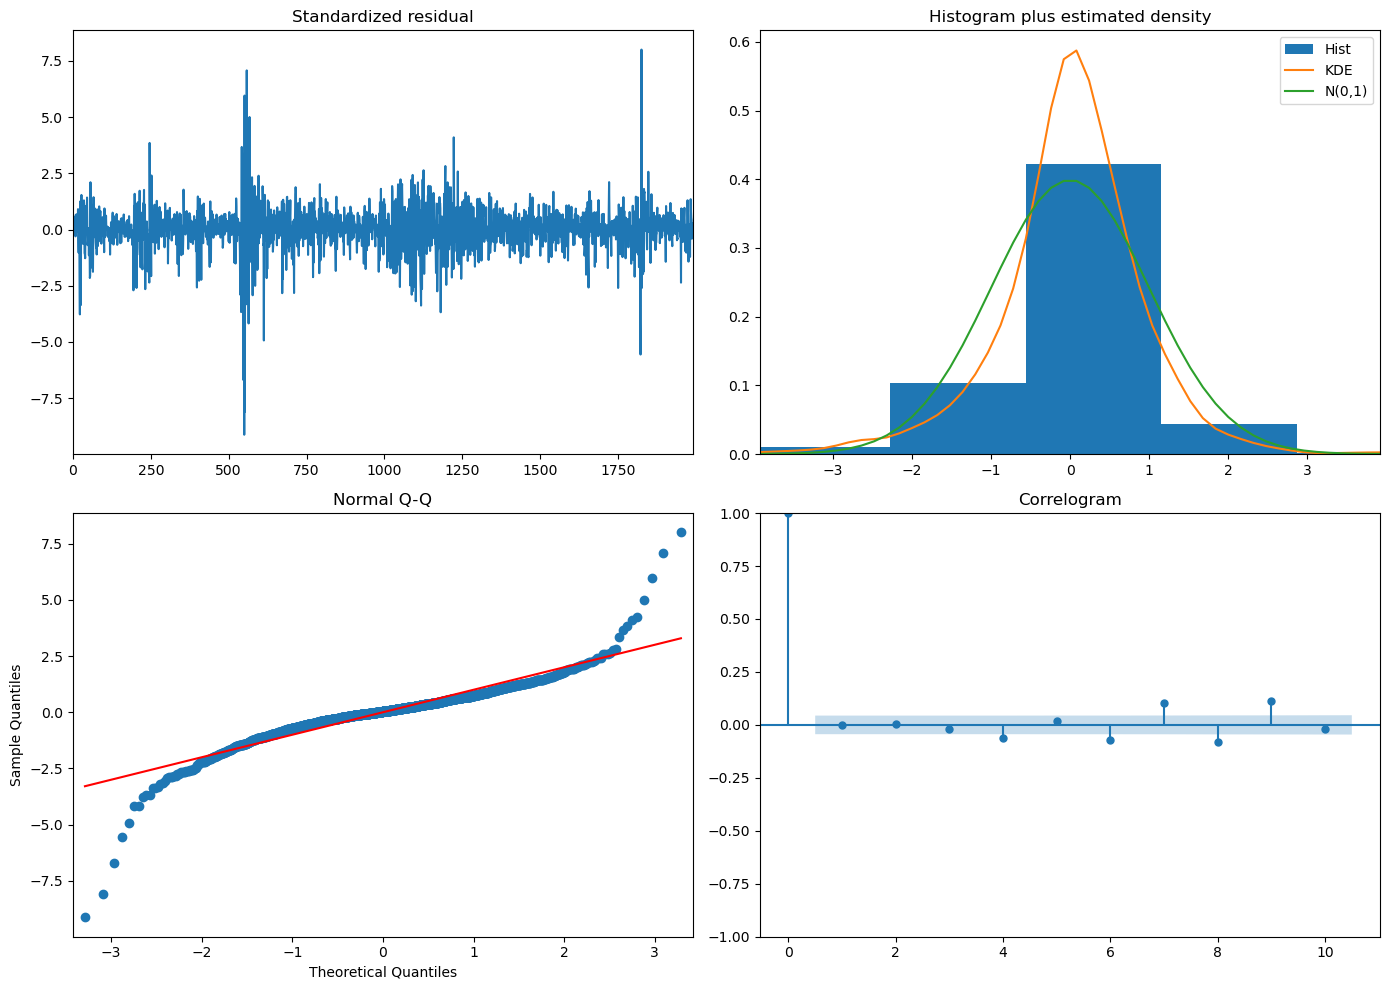


Interpretation:
1. Standardized residuals: Should appear random (no patterns)
2. Histogram + KDE: Should look normally distributed
3. Q-Q plot: Points should fall on red line (normality)
4. Correlogram: Most bars should be within blue bands (no autocorrelation)


In [24]:
# Plot diagnostics for auto-selected model
auto_model.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("="*60)
print("1. Standardized residuals: Should appear random (no patterns)")
print("2. Histogram + KDE: Should look normally distributed")
print("3. Q-Q plot: Points should fall on red line (normality)")
print("4. Correlogram: Most bars should be within blue bands (no autocorrelation)")

## Visualize Model Fit: ACF and PACF

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) help identify appropriate model orders.